# TEST 2:

In [1]:
# Add the 'src' as root folder, to find other modules in the project
import sys
sys.path.append("../")

In [2]:
# local imports
from simulator.swing_equation import swing_equation

In [3]:
# external imports
import torch
import os
import pandas as pd
import numpy as np

from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi.utils import BoxUniform, posterior_nn
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import kurtosis, skew

/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks-1/.venv/lib64/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Define the experimental setup variables
num_simulations = 10000
dts = [0.1, 0.05, 0.01]
T = 10
param_names = ['c1', 'c2', 'P0', 'P1', 'epsilon']

# Define output directories for results
dir_path_plots = '../../results/simulation_length/plots/'
dir_path_tables = '../../results/simulation_length/csv/'

# Create the directories
os.makedirs(dir_path_plots, exist_ok=True)
os.makedirs(dir_path_tables, exist_ok=True)

# Define the prior distribution for the parameters
prior_low = torch.tensor([0.1, 1.0, 0.1, 40.0, 0.1])
prior_high = torch.tensor([10.0, 100.0, 10.0, 70.0, 10.0])

prior = BoxUniform(low=prior_low, high=prior_high)

# Simulation parameters
simulator = swing_equation
proposal = prior
num_simulations = 20000
num_workers = 20
simulation_batch_size = 1
seed = None
show_progress_bar = True

# Density estimator parameters
model = 'maf'
hidden_features = 50
num_transforms = 10
z_score_x = 'independent'
z_score_theta = 'independent'
num_bins = 10
num_components = 10

# Define the true parameters for training and evaluation
theta_true = torch.tensor([4.0, 40.0, 3.0, 60.0, 7.0])

# Define the simulators with different timesteps and observations from them
sim_ops = []

for dt in dts:
    
    # Wrap the simulator to allow timestep change
    def wrap_simulator(theta, dt=dt):
        return swing_equation(theta, dt=dt, T=T)
    
    # Generate observation for the current simulator function
    observation = wrap_simulator(theta_true)
    
    # Append simulator function, observation, and total length of the simulation
    sim_ops.append((wrap_simulator, observation, T / dt))

In [5]:
# Run inference and collect resulting posteriors
posteriors = []

for pre_simulator, observation, t in sim_ops:

    # Wrap the simulator function for compatibility with SBI
    post_simulator, proposal = prepare_for_sbi(pre_simulator, proposal)

    # Instantiate the neural density estimator
    neural_posterior = posterior_nn(
        model=model, 
        hidden_features=hidden_features, 
        num_transforms=num_transforms, 
        num_bins=num_bins, 
        num_components=num_components, 
        z_score_theta=z_score_theta, 
        z_score_x=z_score_x
    )

    # Set up the inference procedure with the SNPE procedure
    inference = SNPE(prior=prior)

    # Run the inference procedure to generate samples and corresponding simulated data points
    theta, x = simulate_for_sbi(
        simulator=post_simulator, 
        proposal=proposal, 
        num_simulations=num_simulations, 
        num_workers=num_workers, 
        simulation_batch_size=simulation_batch_size, 
        seed=seed, 
        show_progress_bar=show_progress_bar
    )

    # Train the neural density estimator
    density_estimator = inference.append_simulations(theta, x).train()

    # Build the posterior for the given parameters
    posterior = inference.build_posterior(density_estimator).set_default_x(observation)

    # add (posterior, simulation length) to the posteriors list
    posteriors.append((posterior, t))

Running 20000 simulations in 20000 batches.: 100%|██████████| 20000/20000 [00:41<00:00, 477.58it/s]


 Neural network successfully converged after 93 epochs.

Running 20000 simulations in 20000 batches.: 100%|██████████| 20000/20000 [00:27<00:00, 731.60it/s]


 Neural network successfully converged after 125 epochs.

Running 20000 simulations in 20000 batches.: 100%|██████████| 20000/20000 [01:46<00:00, 187.46it/s]


 Neural network successfully converged after 102 epochs.

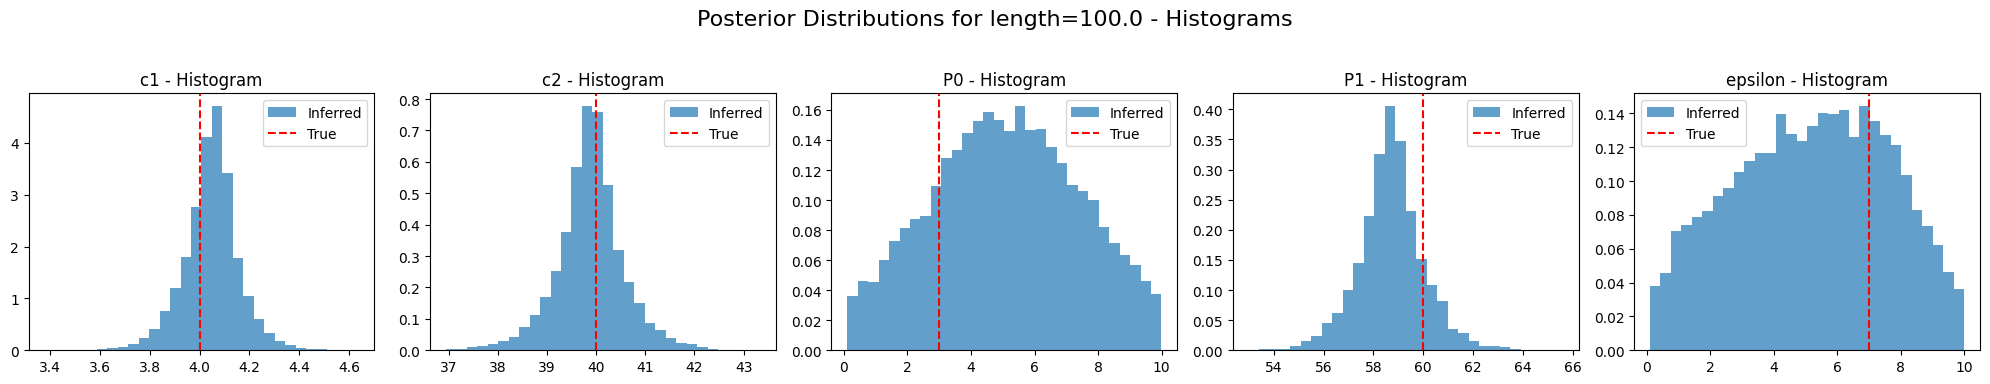

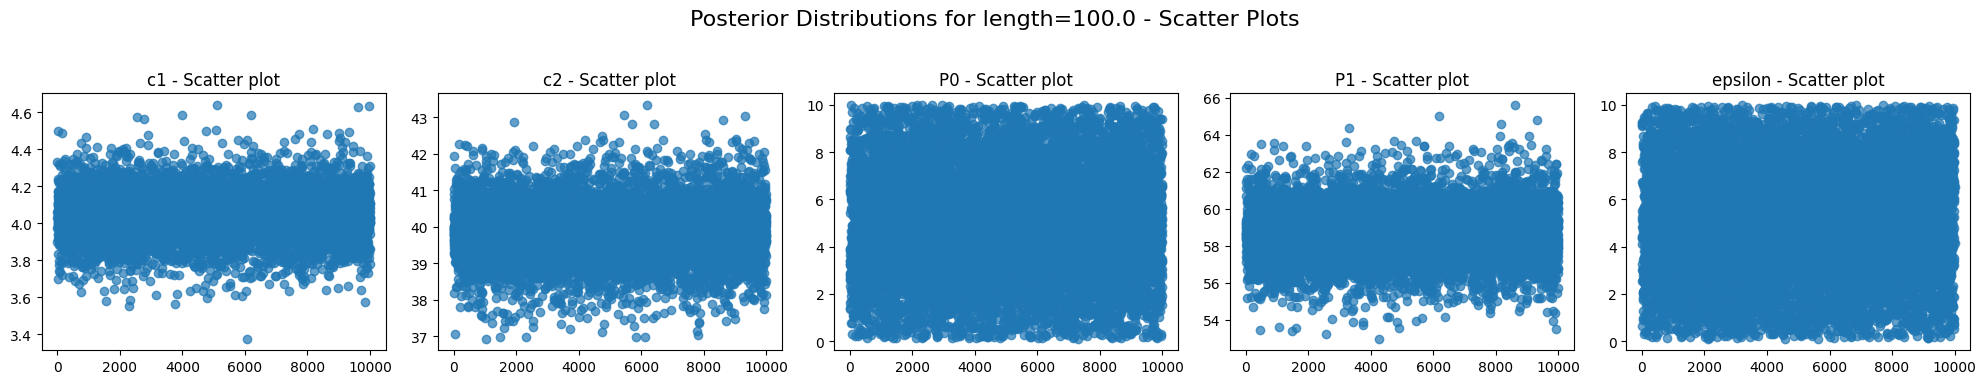

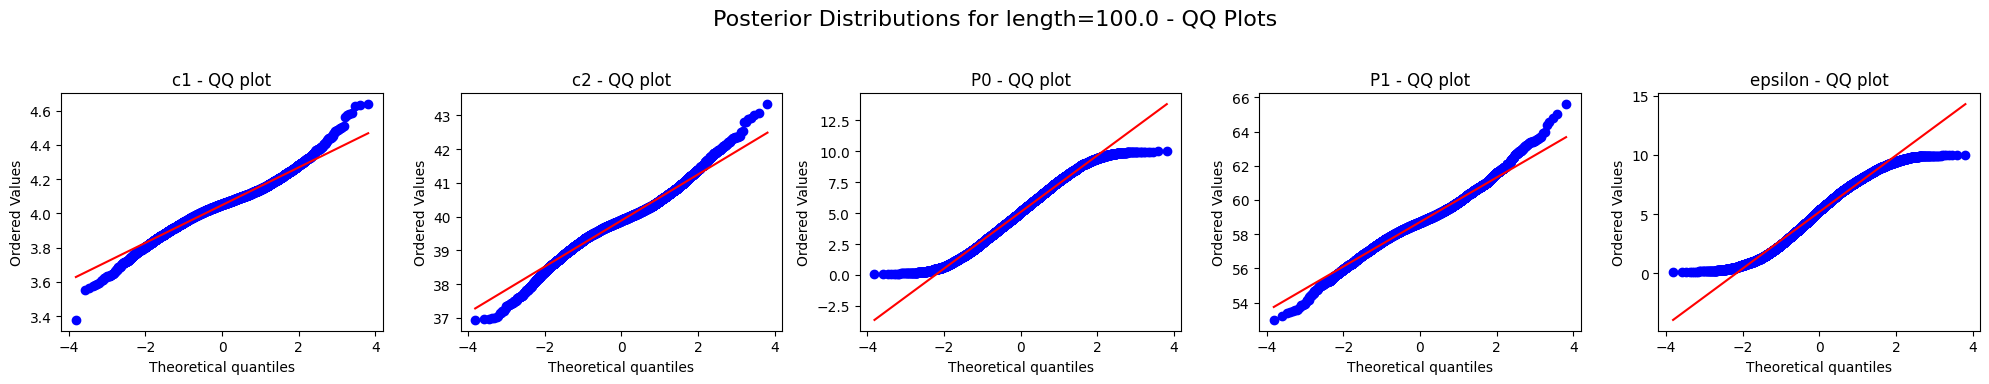

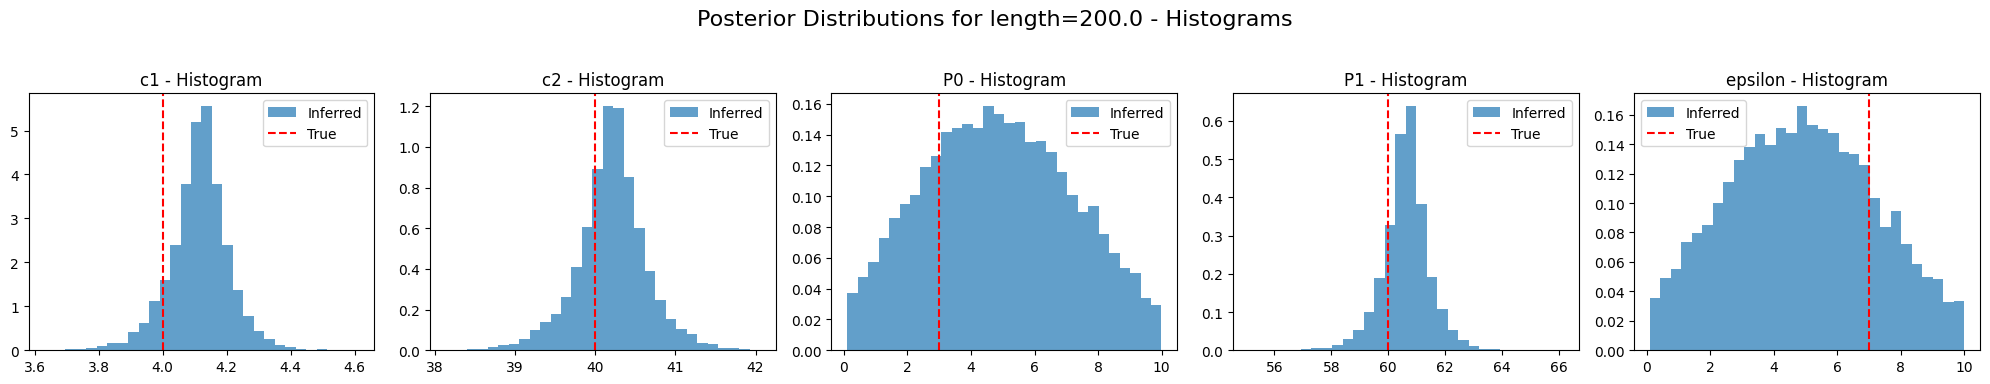

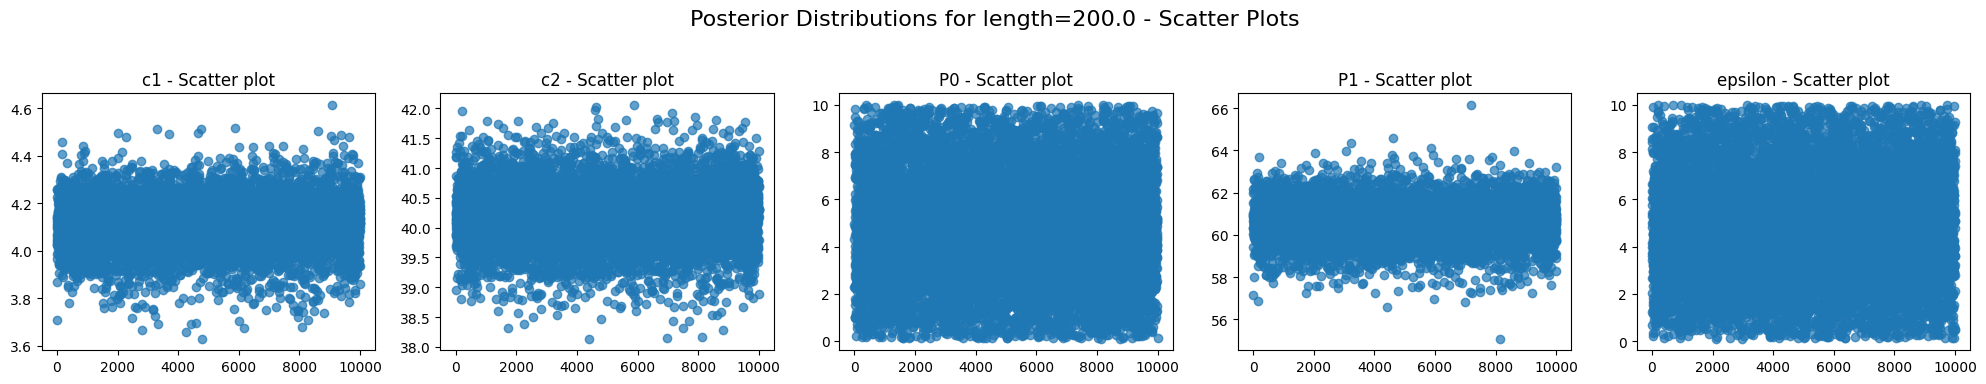

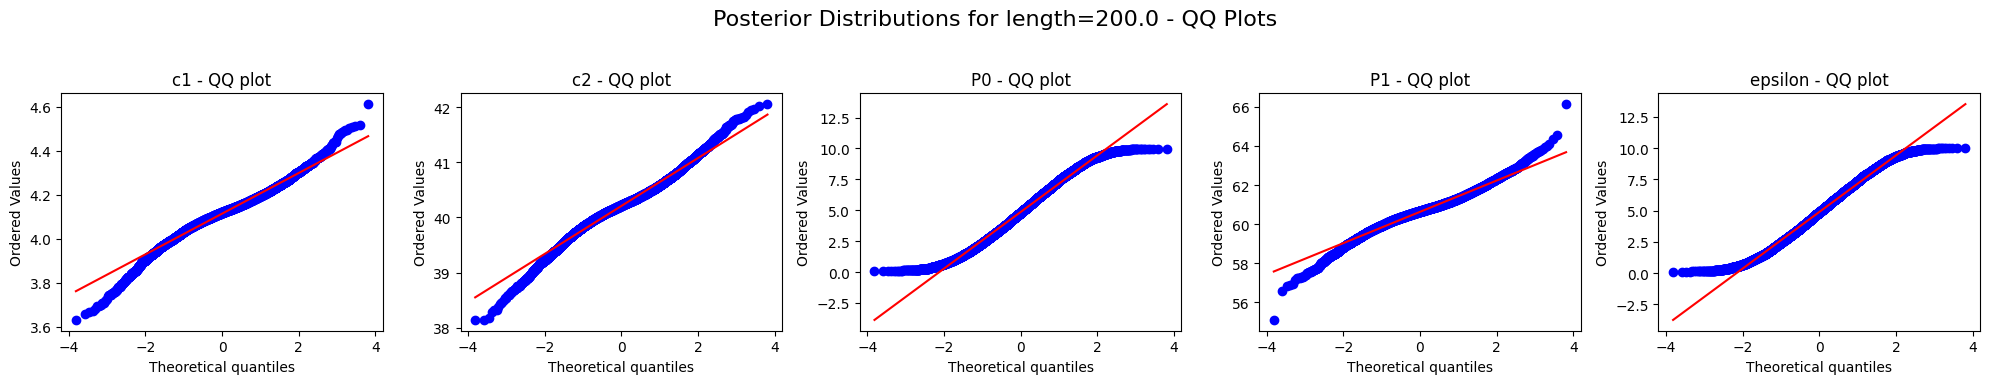

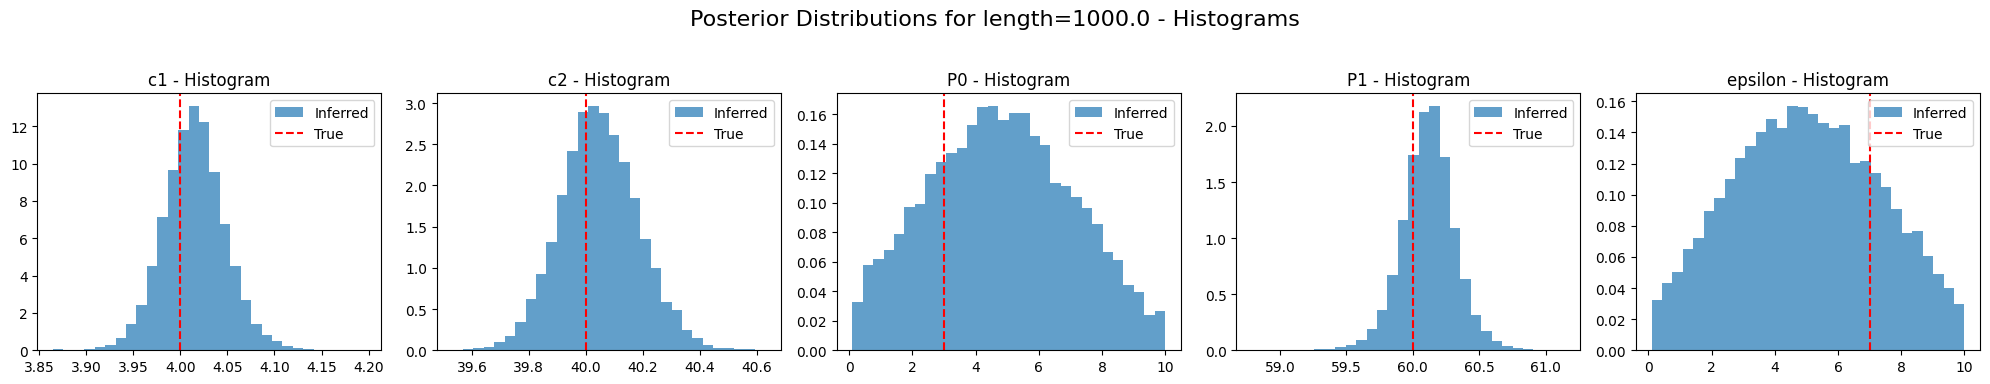

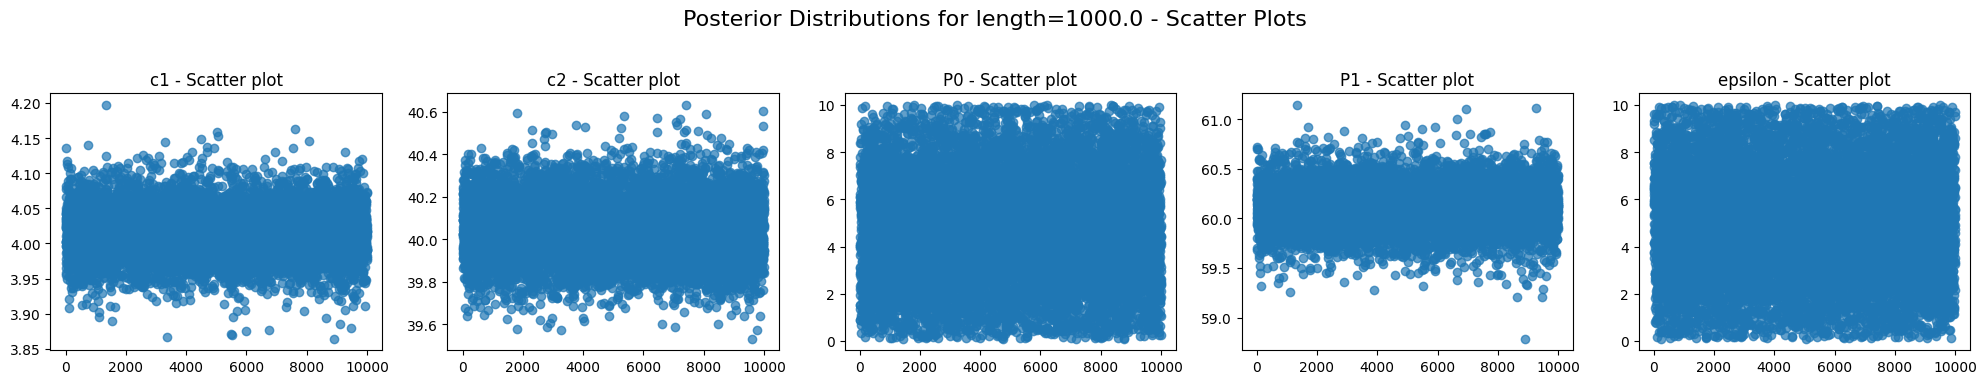

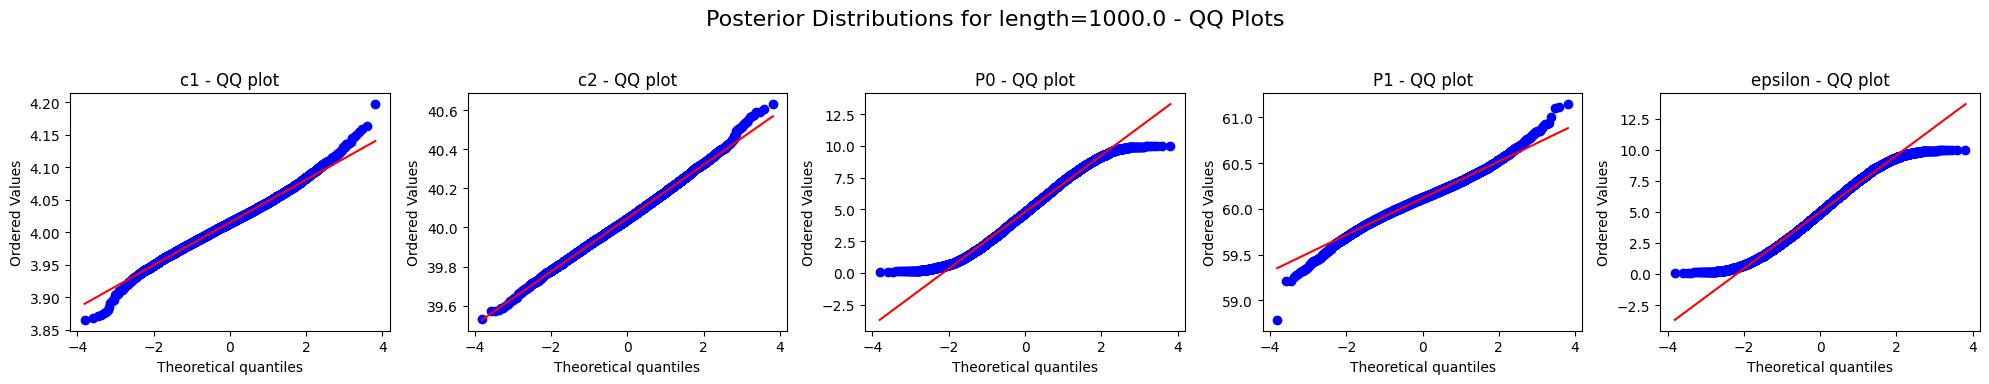

In [6]:
for posterior, t in posteriors:
    
    # Extract posterior distributions for current T
    posterior_samples = posterior.sample((10000,), show_progress_bars=False)

    # Create separate figures for each type of plot
    fig1, axes1 = plt.subplots(1, len(param_names), figsize=(20, 4))
    fig2, axes2 = plt.subplots(1, len(param_names), figsize=(20, 4))
    fig3, axes3 = plt.subplots(1, len(param_names), figsize=(20, 4))

    # Plot each parameter for current length
    for j in range(len(param_names)):
        parameter_samples = posterior_samples[:, j]
        
        # Histogram
        axes1[j].hist(parameter_samples, bins=30, density=True, alpha=0.7, label='Inferred')
        axes1[j].axvline(x=theta_true[j], color='red', linestyle='--', label='True')

        axes1[j].set_title(param_names[j] + ' - Histogram')
        axes1[j].legend()
        
        # Scatter plot
        axes2[j].scatter(range(len(parameter_samples)), parameter_samples, alpha=0.7)
        axes2[j].set_title(param_names[j] + ' - Scatter plot')
        
        # QQ plot
        stats.probplot(parameter_samples, dist="norm", plot=axes3[j])
        axes3[j].set_title(param_names[j] + ' - QQ plot')

    # Set titles for the figures
    fig1.suptitle(f'Posterior Distributions for length={t} - Histograms', fontsize=16)
    fig2.suptitle(f'Posterior Distributions for length={t} - Scatter Plots', fontsize=16)
    fig3.suptitle(f'Posterior Distributions for length={t} - QQ Plots', fontsize=16)

    # Adjust layout and save the figures
    fig1.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig1.savefig(os.path.join(dir_path_plots, f'histogram_length_{t}.pdf'))
    fig2.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig2.savefig(os.path.join(dir_path_plots, f'scatter_length_{t}.pdf'))
    fig3.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig3.savefig(os.path.join(dir_path_plots, f'qqplot_length_{t}.pdf'))

    plt.show()


In [7]:
# Initialize lists to store the results
medians = []
stds = []
kurtoses = []
skews = []

# Calculate the statistics for each posterior
for posterior, t in posteriors:
    samples = posterior.sample((10000,), show_progress_bars=False)
    samples_np = samples.numpy()
    median = np.median(samples_np, axis=0)
    std = np.std(samples_np, axis=0)
    kurt = kurtosis(samples_np, axis=0)
    skewness = skew(samples_np, axis=0)
    
    medians.append([t] + list(median))
    stds.append([t] + list(std)) 
    kurtoses.append([t] + list(kurt))
    skews.append([t] + list(skewness))

# Create a DataFrame for each statistic
df_medians = pd.DataFrame(medians, columns=['T'] + param_names)
df_medians.set_index('T', inplace=True)

df_stds = pd.DataFrame(stds, columns=['T'] + param_names)
df_stds.set_index('T', inplace=True)

df_kurtoses = pd.DataFrame(kurtoses, columns=['T'] + param_names)
df_kurtoses.set_index('T', inplace=True)

df_skews = pd.DataFrame(skews, columns=['T'] + param_names)
df_skews.set_index('T', inplace=True)

# Save the DataFrames as CSV files in the specified directory
df_medians.to_csv(os.path.join(dir_path_tables, 'medians.csv'))
df_stds.to_csv(os.path.join(dir_path_tables, 'standard_deviations.csv'))
df_kurtoses.to_csv(os.path.join(dir_path_tables, 'kurtoses.csv'))
df_skews.to_csv(os.path.join(dir_path_tables, 'skews.csv'))

# Print the tables
print("Medians:")
print(df_medians)
print("\nStandard Deviations:")
print(df_stds)
print("\nKurtoses:")
print(df_kurtoses)
print("\nSkews:")
print(df_skews)


Medians:
              c1         c2        P0         P1   epsilon
T                                                         
100.0   4.053787  39.877853  5.070235  58.691677  5.402948
200.0   4.119757  40.222008  4.757361  60.658638  4.915307
1000.0  4.013988  40.042511  4.798908  60.115059  5.045470

Standard Deviations:
              c1        c2        P0        P1   epsilon
T                                                       
100.0   0.112190  0.705540  2.303243  1.321358  2.427992
200.0   0.092911  0.448132  2.290671  0.813727  2.303648
1000.0  0.033028  0.137025  2.252905  0.204774  2.296311

Kurtoses:
              c1        c2        P0        P1   epsilon
T                                                       
100.0   1.903307  1.993277 -0.762084  1.552329 -0.890065
200.0   1.480103  1.330301 -0.746913  1.562281 -0.731781
1000.0  0.507730  0.110838 -0.698480  1.202070 -0.734027

Skews:
              c1        c2        P0        P1   epsilon
T                           